In [69]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from datetime import datetime, timedelta
import statsmodels
import matplotlib.pyplot as plt
import seaborn

try:
    from StringIO import StringIO, BytesIO
except ImportError:
    from io import StringIO, BytesIO

try:
    from urllib import urlopen
except ImportError:
    from urllib.request import urlopen

try:
    import pandas.io.data as web
except ImportError:
    import pandas_datareader as web
    
    
%matplotlib inline

In [70]:
url = urlopen('http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip')

# Download Zipfile and create pandas DataFrame
zipfile = ZipFile(BytesIO(url.read()))
FFdata = pd.read_csv(zipfile.open('F-F_Research_Data_Factors.CSV'), 
                     header=0, 
                     names=['Date','MKT-RF','SMB','HML','RF'], 
                     skiprows=3)

# Drop last row of data - String
FFdata = FFdata[:1074]

# Convert YYYYMM into Date
FFdata['Date'] = pd.to_datetime(FFdata['Date'], format = "%Y%m")
FFdata.index = FFdata['Date']
FFdata.drop(FFdata.columns[0], axis=1,inplace=True)

# Drop Days in YYYY-MM-DD
FFdata.index = FFdata.index.map(lambda x: x.strftime('%Y-%m'))

# Convert into float
FFdata = FFdata.astype('float')
FFdata.tail()

,MKT-RF,SMB,HML,RF
2015-08,-6.04,0.48,2.68,0.00
2015-09,-3.08,-2.64,0.52,0.00
2015-10,7.75,-1.97,-0.08,0.00
2015-11,0.56,3.64,-0.52,0.00
2015-12,-2.17,-2.82,-2.58,0.01


In [71]:
# Import Fund Data
# Tweedy, Browne Global Value Fund - Ticker TBGVX from YahooFinance

# Get Data from Yahoo
start = datetime(1950,1,1)
end = datetime(2016,1,1)
f = web.get_data_yahoo('TBGVX', start, end, interval='m')

# Delete Columns
f.drop(f.columns[[0,1,2,3,4]], axis=1, inplace=True)

# Fix Date Column
f.index = f.index.map(lambda x: x.strftime('%Y-%m'))

# Ln Return
f['LnReturn'] = np.log(f['Adj Close']) - np.log(f['Adj Close'].shift(1))
f.head()

,Adj Close,LnReturn
1993-06,2.858413,NaN
1993-07,2.955795,0.033501
1993-08,3.064632,0.036160
1993-09,2.952930,-0.037129
1993-10,3.064632,0.037129


In [72]:
# Merge DF
data2 = pd.concat([f,FFdata], axis=1, sort=False)

# Excess Return
data2['XRtrn'] = (data2['LnReturn'] * 100 - data2['RF'])

# Align Data
df = data2[np.isfinite(data2['XRtrn'])]

df.tail()

,Adj Close,LnReturn,MKT-RF,SMB,HML,RF,XRtrn
2015-08,21.875895,-0.045687,-6.04,0.48,2.68,0.00,-4.568743
2015-09,21.321968,-0.025647,-3.08,-2.64,0.52,0.00,-2.564742
2015-10,22.463911,0.052172,7.75,-1.97,-0.08,0.00,5.217216
2015-11,22.370169,-0.004182,0.56,3.64,-0.52,0.00,-0.418175
2015-12,20.844736,-0.070627,-2.17,-2.82,-2.58,0.01,-7.072687


In [73]:
# df = data2[np.isfinite(data2['XRtrn'])]

y = df['XRtrn']
X = df.ix[:,[2,3,4]]
X = sm.add_constant(X)

model = statsmodels.api.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  XRtrn   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     53.43
Date:                Fri, 18 Jan 2019   Prob (F-statistic):           4.61e-27
Time:                        09:33:20   Log-Likelihood:                -709.50
No. Observations:                 270   AIC:                             1427.
Df Residuals:                     266   BIC:                             1441.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1437      0.208      0.690      0.4

/home/pindaroso/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


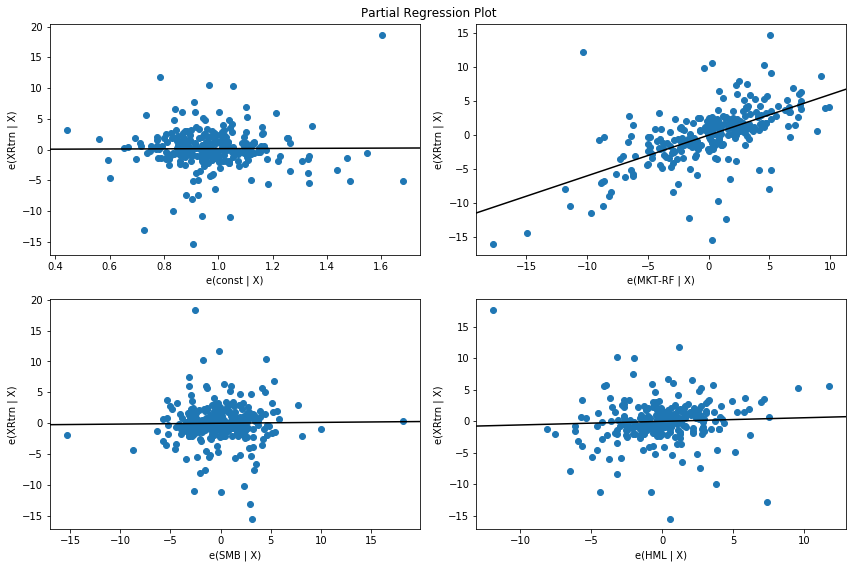

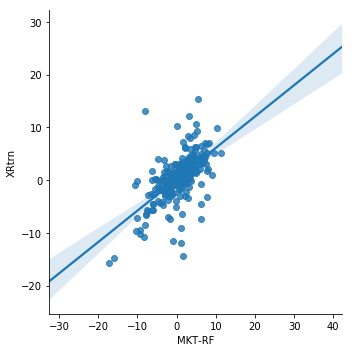

In [74]:
fig = plt.figure(figsize=(12,8))
fig = statsmodels.api.graphics.plot_partregress_grid(results, fig = fig)
plt.show()

seaborn.lmplot(x="MKT-RF", y="XRtrn", data=data2)

In [75]:
df.tail()

,Adj Close,LnReturn,MKT-RF,SMB,HML,RF,XRtrn
2015-08,21.875895,-0.045687,-6.04,0.48,2.68,0.00,-4.568743
2015-09,21.321968,-0.025647,-3.08,-2.64,0.52,0.00,-2.564742
2015-10,22.463911,0.052172,7.75,-1.97,-0.08,0.00,5.217216
2015-11,22.370169,-0.004182,0.56,3.64,-0.52,0.00,-0.418175
2015-12,20.844736,-0.070627,-2.17,-2.82,-2.58,0.01,-7.072687
